# **Import all needed dependancies**

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer


# **Part 1: Building up a basic predictive mode**

# **Data cleaning and transformation**

In [2]:
def get_numeric_and_categorical(df):
  """
  Return a list of categroical and numerical variables in a dataframe
  df: A dataframe
  """
  numerical_variables = df.select_dtypes(include=['number']).columns.tolist()
  categorical_variables = df.select_dtypes(include=['object']).columns.tolist()

  return numerical_variables, categorical_variables


In [3]:
def print_summary(df):
  """Show a summary of all missing values as well as the summary statistics and
  number of duplicates
  df: A dataframe
  """
  # Create a dataframe with name of columns, number of missing values, and
  #percentages those missing values represent
  missing_summary = pd.DataFrame({'Column': df.columns,
                                  'Missing Values': df.isnull().sum(),
                                  'Percentage':
                                   (df.isnull().sum() / len(df)) * 100})
  # Filter the dataframe to only show only with missing values
  missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

  # Display summary statistics
  print('Summary Statistics: ')
  summary_stats = df.describe(include='all').transpose()
  print(tabulate(summary_stats, headers='keys', tablefmt='pipe'))

  # Display missing values with percentages
  print(f'Missing Values: ')
  print(tabulate(missing_summary, headers='keys', tablefmt='pipe'))

  # print the number of duplicate rows
  duplicate_count = df.duplicated().sum()
  print(f"\nNumber of duplicate rows: {duplicate_count}")
  print('\n')


In [4]:
def remove_outliers_iqr(data, multiplier=1.5):
  """
  A method to identify and remove outliers using the
  Interquarite Range (IQR) method
  data: A dataframe
  multiplier: A numerical value for the IQR outlier handling method
  """
  # create a copy of the data frame
  data_without_outliers = data.copy()

  # get numerical variables
  numerical_variables, _ = get_numeric_and_categorical(data_without_outliers)

  # Identify and remove outliers using IQR method
  for col in numerical_variables:
    # get first and third quantiles
    Q1 = data_without_outliers[col].quantile(0.25)
    Q3 = data_without_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    # get upper and lower bounds
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    # get length before removing outliers
    count_before = len(data_without_outliers)
    data_without_outliers = data_without_outliers[
        (data_without_outliers[col] >= lower_bound) &
        (data_without_outliers[col] <= upper_bound)
        ]
    # get length after removing outliers
    count_after = len(data_without_outliers)
    # get a sense of how much data was removed
    print(f"Rows count after removing outliers from {col}: {count_after} rows")
    # get the differance after removal, delta
    delta = count_before - count_after
    print(f"Removed {delta} rows ({(delta)/count_before*100:.2f}%)")

  return data_without_outliers


In [5]:
def cap_outliers_iqr(data, multiplier=1.5):
  """
  A method to identify and cap outliers using the
  Interquarite Range (IQR) method
  data: A dataframe
  multiplier: A numerical value for the IQR outlier handling method
  """
  # Create a copy of the data frame
  data_with_capped_outliers = data.copy()

  # Get numerical variables
  numerical_variables, _ = (
  get_numeric_and_categorical(data_with_capped_outliers)
  )
  # Cap outliers using IQR method
  for col in numerical_variables:
      # Get first and third quantiles
      Q1 = data_with_capped_outliers[col].quantile(0.25)
      Q3 = data_with_capped_outliers[col].quantile(0.75)
      IQR = Q3 - Q1

      # Get upper and lower bounds
      lower_bound = Q1 - multiplier * IQR
      upper_bound = Q3 + multiplier * IQR

      # Cap the values that are outside the bounds
      data_with_capped_outliers[col] = data_with_capped_outliers[col].apply(
          lambda x: lower_bound if x < lower_bound
          else (upper_bound if x > upper_bound else x)
      )

  return data_with_capped_outliers


In [6]:
def remove_outliers_z_score(data, threshold=3):
  # create a copy of the data frame
  data_without_outliers = data.copy()
  # Select numeric columns
  numerical_variables = data_without_outliers.select_dtypes(include=[np.number])
  # Compute Z-scores
  z_scores = np.abs(stats.zscore(numerical_variables))
  # remove outliers
  data_without_outliers = data_without_outliers[(z_scores < threshold).all(axis=1)]

  # get a sense of outliers per column
  outliers = (z_scores > threshold)
  outlier_counts = np.sum(outliers, axis=0)
  print("Number of outliers per column:\n", outlier_counts)

  return data_without_outliers

In [11]:
def load_and_clean_data(path, handle_outlier='remove', multiplier=1.5):
  """
  A method to load and clean a dataset.
  path: the path from which the dataset will be loaded.
  handle_outlier: A variable to indicate outlier strategy, (cap or remove).
  multiplier: A numerical value for the IQR outlier handling method
  """

  #load the dataset into a pandas datatframe
  data = pd.read_csv(path)

  # print the shape of the dataframe
  print(f'Shape of data before cleaning: {data.shape}')

  # get the neumerical and categorical variables
  numerical_variables, categorical_variables = get_numeric_and_categorical(data)

  # convert price column to numeric
  data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)

  # For each categorical variable,
  #remove empty strings or lists and replace them with Nan
  data[categorical_variables] = (
      data[categorical_variables].
      apply(lambda col:
            col.map(lambda x: np.nan if x == "" or x == "[]" else x))
      )

  # Show a summary of all missing values as well as the summary statistics
  print_summary(data)


  # Drop unnecessary columns
  columns_to_drop = [
      'id', 'name', 'description', 'host_id', 'host_name',
      'calendar_last_scraped', 'bathrooms_text', 'latitude', 'longitude',
      'first_review', 'last_review', 'host_since', 'amenities'
  ]
  data = data.drop(columns=columns_to_drop)
  print(f'\nShape of data after dropping columns: {data.shape}')
  print_summary(data)
  # Drop duplicates if any
  data.drop_duplicates(inplace=True)
  print(f'\nShape of data after dropping duplicates: {data.shape}')

  # Drop rows with NaN values
  data.dropna(axis=0, how='any', inplace=True)
  print(f'\nShape of data after dropping rows with missing values: {data.shape}')

  # get updated numerical and categorical vairables
  numerical_variables, categorical_variables = get_numeric_and_categorical(data)

  # handle outliers based on selected strategy
  if handle_outlier.lower() =='cap_iqr':
    # remove outliers
    print('Capping outliers using IQR method')
    data = cap_outliers_iqr(data, multiplier)
    # Drop duplicates if any
    data.drop_duplicates(inplace=True)
  elif handle_outlier.lower() == 'z':
    # remove outliers using z-method
    remove_outliers_z_score(data, threshold=3)
  else:
    # Else, default to iqr method
    print('Removing outliers using IQR method')
    data = remove_outliers_iqr(data, multiplier)

  # Convert percentage strings to float
  for col in ['host_response_rate', 'host_acceptance_rate']:
    data[col] = data[col].str.replace('%', '').astype(float) / 100

  # Convert boolean columns
  if 'host_is_superhost' in data.columns:
      data['host_is_superhost'] = data['host_is_superhost'].map({'t': 1, 'f': 0})


  # get updated numerical and categorical vairables after latest transformation
  numerical_variables, categorical_variables = get_numeric_and_categorical(data)
  #data = apply_log_transformation(data)
  data['price'] = np.log1p(data['price'])
  # normalise the data.
  scaler = StandardScaler()
  data[numerical_variables] = scaler.fit_transform(data[numerical_variables])
  # rename the price column to reflect transformation
  data.rename(columns={'price': 'log_price'}, inplace=True)

  print(f'Summary after cleaning')
  print_summary(data)
  # Show the shape of the resulting dataframe
  print(f'Shape of data after cleaning: {data.shape}')

  return data


In [12]:
# load and clean the dataset
data = load_and_clean_data('London_Listings.csv', handle_outlier='iqr', multiplier=1.5)

Shape of data before cleaning: (66679, 31)
Summary Statistics: 
|                                |   count |   unique | top                                                                         |   freq |           mean |           std |        min |           25% |           50% |           75% |             max |
|:-------------------------------|--------:|---------:|:----------------------------------------------------------------------------|-------:|---------------:|--------------:|-----------:|--------------:|--------------:|--------------:|----------------:|
| id                             |   66679 |      nan | nan                                                                         |    nan |    6.12924e+17 |   4.72814e+17 | 13913      |   3.98249e+07 |   8.04e+17    |   1.03e+18    |     1.18e+18    |
| name                           |   66679 |    64452 | Flat in London                                                              |     25 |  nan           | nan        

# **Data exploration**

In [13]:
def x_vs_y_bar_plot(data, x, y, save=True):
  """""
  Create a bar plot to visualize the distribution of prices across different
  neighborhoods
  data: A dataframe
  x: Feature/variable x on the bar plot
  y: Feature/variable y on the bar plot
  save: A boolean to save the created figure
  """""
  # Early return if x or y not columns in the dataframe
  if x not in data.columns:
    print(f'{x} is not a coumn in the given dataframe')
    return
  elif y not in data.columns:
    print(f'{y} is not a coumn in the given dataframe')
    return

  # Create the barplot
  plt.figure(figsize=(12, 6))
  sns.barplot(data=data, x=x, y=y, estimator='mean')

  # Rotate x-axis labels for better readability
  plt.xticks(rotation=90)

  # Add labels and title
  plt.title(f'Mean {y} per {x}')
  plt.xlabel(x)
  plt.ylabel(y)
  plt.tight_layout()


  # save plot if specified
  if save:
    plt.savefig(f'Mean {y} per {x}')

  # Show the plot
  plt.show()
  # close the plot
  plt.close()


In [14]:
def plot_x_vs_y(data, x, y, save=True):
  """
  Create a scatter plot to visualize the relationship between x and y
  data: A dataframe
  x: Feature/variable x on the scatter plot
  y: Feature/variable y on the scatter plot
  save: A boolean to save the created figure
  """

  # Early return if x or y not columns in the dataframe
  if x not in data.columns:
    print(f'{x} is not a coumn in the given dataframe')
    return
  elif y not in data.columns:
    print(f'{y} is not a coumn in the given dataframe')
    return
  # Group by x and calculate the mean of y
  mean_y_by_x = (
      data.groupby(x)[y].mean().reset_index()
      )
  # Create the scatter plot of x vs. y
  plt.figure(figsize=(10, 6))
  plt.scatter(
      mean_y_by_x[x],
      mean_y_by_x[y], color='darkblue', s=60, marker='o')

  # Add labels and title
  plt.title(f'{x} vs. {y}', fontsize=14)
  plt.xlabel(x, fontsize=12)
  plt.ylabel(y, fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()

  # save the figure if specified
  if save:
    plt.savefig(f'{x}_vs_{y}')

  # Show the plot
  plt.show()
  # close the plot
  plt.close()


In [15]:
def plot_hist(data, target_feature, save=True):
  """
  Create a histogram to visualize the distirbution of the target feature
  data: A dataframe
  target_feature: Feature to be plotted
  save: A boolean to save the created figure
  """
  if target_feature not in data.columns:
    print(f'{target_feature} is not a coumn in the given dataframe')
    return

  # Create the histogram
  plt.figure(figsize=(8, 6))
  plt.hist(
      data[target_feature],
      bins=20, color='skyblue',
      edgecolor='black', alpha=0.7)

  # Add labels and title
  plt.title(f'Histogram of {target_feature}')
  plt.xlabel(f'{target_feature}')
  plt.ylabel('Frequency (Count of Listings)')
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # save plot if specified
  if save:
    plt.savefig(f'{target_feature}_hist')

  # Show the plot
  plt.show()
  # close the plot
  plt.close()


In [16]:
def correlation_matrix(data, target, print_corr=True, save=True):
  """
  Get the correlation matrix between numerical variables for a dataframe
  data: A dataframe
  target: A variable to check correlation of other variables with
  print_corr: A boolean to print correlations with target variable
  save: A boolean to save the created figure
  """
  numerical_variables, _ = get_numeric_and_categorical(data)
  # Calculate correlation matrix
  correlation_matrix = data[numerical_variables].corr(method='pearson')

  # Create heatmap
  plt.figure(figsize=(12, 10))
  mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
  heatmap = sns.heatmap(correlation_matrix,
                      annot=True,
                      cmap='coolwarm',
                      linewidths=0.5,
                      fmt='.2f',
                      mask=mask,
                      cbar_kws={"shrink": .8})

  plt.title('Correlation Matrix of Numerical Variables', fontsize=16)
  plt.tight_layout()
  # Save plot if specified
  if save:
    plt.savefig('correlation_matrix')

  # Show the plot
  plt.show()
  # close the plot
  plt.close()

  # Print if specified
  if print_corr:
    # Print top correlations with target
    target_corr = correlation_matrix[target].sort_values(ascending=False)
    print(f"Top correlations with {target}:")
    print(target_corr)



In [17]:
def scatter_matrix_plot(data, selected_variables, save=True):
  """
  Get the scatter plot matrix between selected numerical
  variables for a dataframe
  data: A dataframe
  selected_variables: Numerical variables for the scatter plot
  save: A boolean to save the created figure
  """
  # Early return if one of the columns is not in the dataframe
  numerical_variables, _ = get_numeric_and_categorical(data)
  for var in selected_variables:
    if var not in numerical_variables:
      print(f'{var} is not a coumn in the given dataframe or not numerical')
      return

  subset_data = data[selected_variables]
  # Create the scatter matrix (using Pandas)
  scatter_matrix(subset_data, alpha=0.5, figsize=(8, 8), diagonal='hist')

  # Save plot if specified
  if save:
    plt.savefig('scatter_matrix_plot')

  # Show the plot
  plt.show()
  # close the plot
  plt.close()



In [18]:
def mean_price_for_top_10_x(data, target_feature, save=True):
  """
  Get a bar plot of the average price for the top 10 frequent elements in a
  column
  data: A dataframe
  target_feature: Feature to be plotted
  save: A boolean to save the created figure
  """
  # Early return if the column is not in the dataset
  if target_feature not in data.columns:
    print(f'Column {target_feature} not found in dataset')
    return

  # Get top 10 most frequent elements in the column/feature
  top_10_x = data[target_feature].value_counts().nlargest(10).index
  # create a data frame with properties in the top 10
  df_top_x = data[data[target_feature].isin(top_10_x )]

  # Groups by the feature/column and calculate the mean price
  mean_price_by_property_type = (
      df_top_x.
      groupby(target_feature)['log_price'].mean().reset_index()
      )

  # Create bar plot
  plt.figure(figsize=(12, 6))
  sns.barplot(
      x=target_feature,
      y='log_price',
      data=mean_price_by_property_type)

  # Add labels and title
  plt.title(f'Mean Price by {target_feature} (Top 10)', fontsize=14)
  plt.xlabel(target_feature, fontsize=12)
  plt.ylabel('Mean Price', fontsize=12)
  plt.xticks(rotation=45, ha='right')
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()

  # Save plot if specified
  if save:
    plt.savefig(f'top_10_{target_feature}_mean_price')

  # Show plot
  plt.show()
  # close the plot
  plt.close()


In [19]:
def plot_bar_count(data, target_feature, save=True):
  """
  Get a count plot of (listings for) a given feature
  data: A dataframe
  target_feature: feature to be plotted
  save: A boolean to save the created figure
  """
  # Early return if the column is not in the dataframe
  if target_feature not in data.columns:
    print(f'Column {target_feature} not found in dataframe')
    return
  # Create barcount
  plt.figure(figsize=(8, 6))
  sns.countplot(x=target_feature, data=data) # Pastel palette

  # Add labels and title
  plt.title(f'Count of listings by {target_feature}', fontsize=14)
  plt.xlabel(target_feature, fontsize=12)
  plt.ylabel('Count of Listings', fontsize=12)
  plt.tight_layout()

  # Save plot if specified
  if save:
    plt.savefig(f'{target_feature}_count_plot')
  plt.show()
  # close the plot
  plt.close()


***5. Plots***

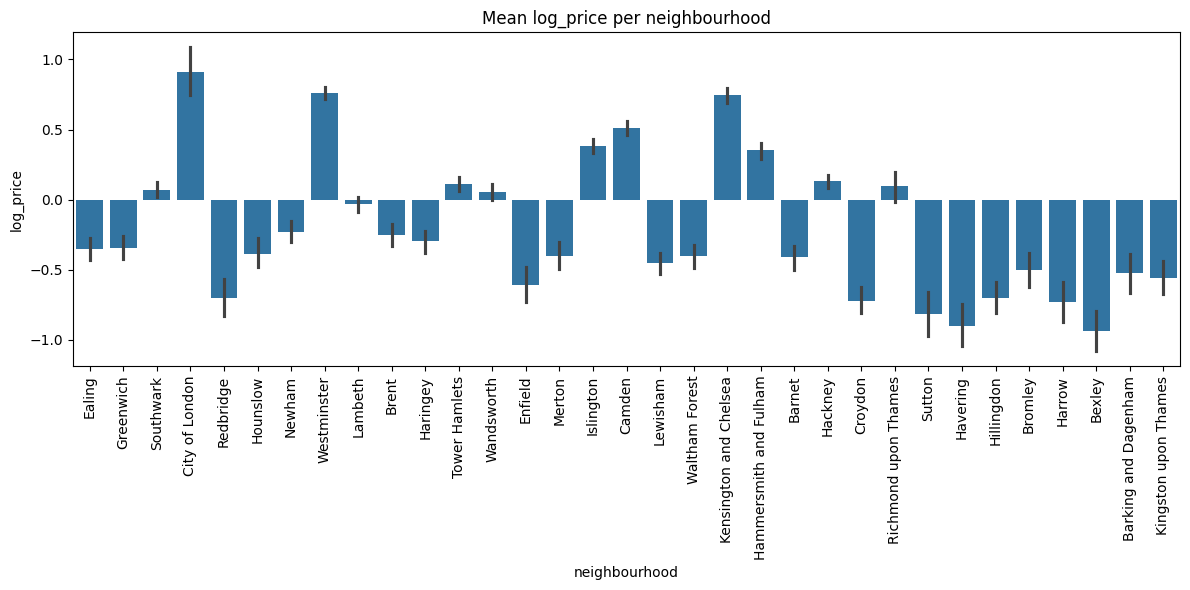

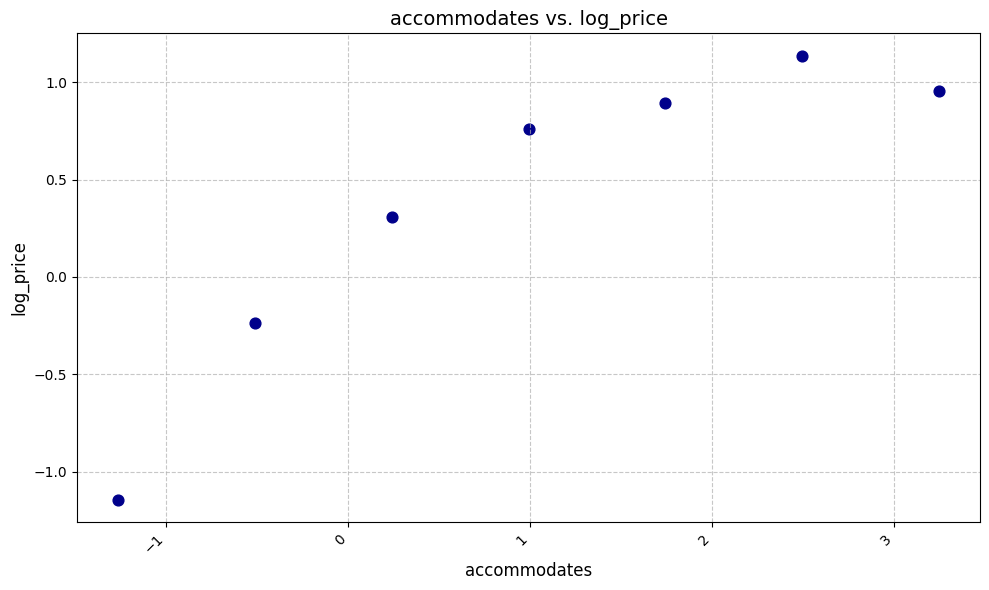

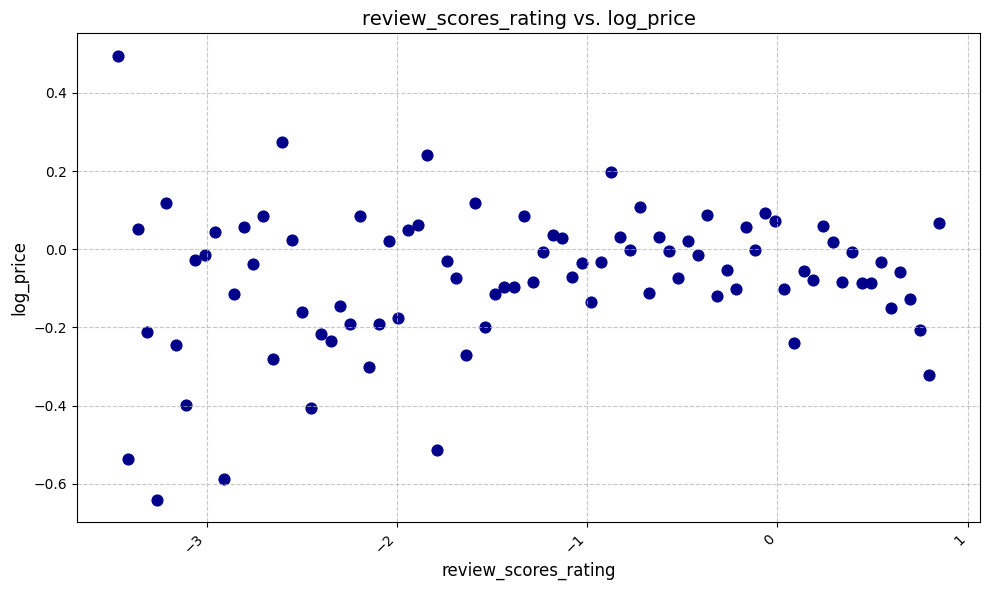

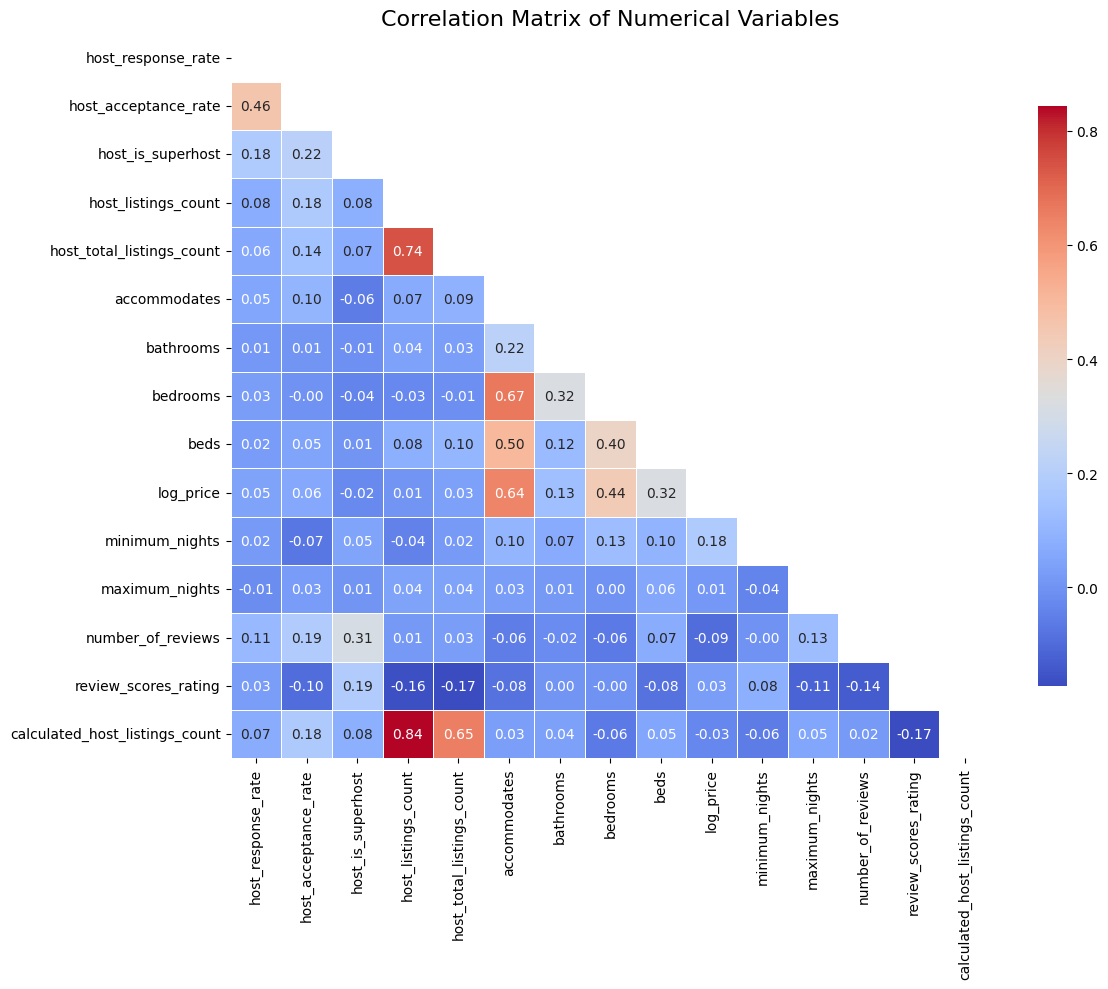

Top correlations with log_price:
log_price                         1.000000
accommodates                      0.639065
bedrooms                          0.436436
beds                              0.322540
minimum_nights                    0.182556
bathrooms                         0.134007
host_acceptance_rate              0.059456
host_response_rate                0.045284
host_total_listings_count         0.034423
review_scores_rating              0.028146
maximum_nights                    0.011681
host_listings_count               0.005764
host_is_superhost                -0.024420
calculated_host_listings_count   -0.030969
number_of_reviews                -0.093462
Name: log_price, dtype: float64


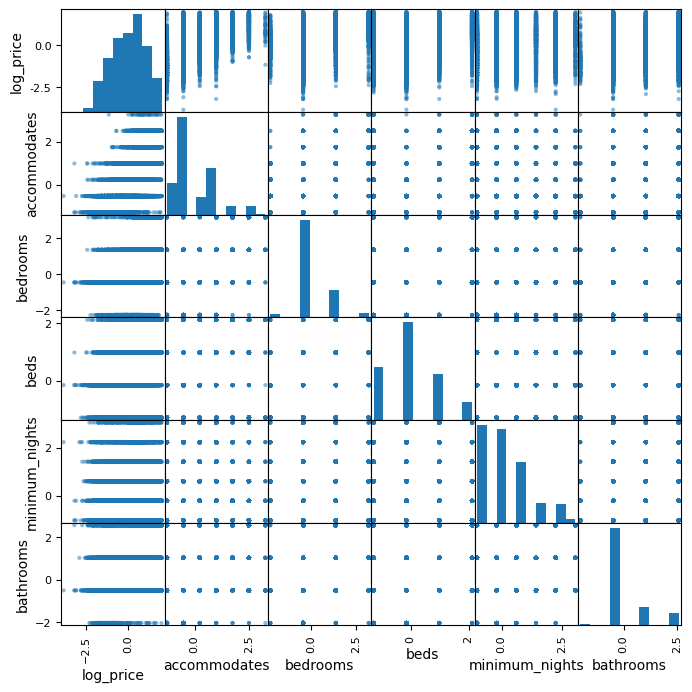

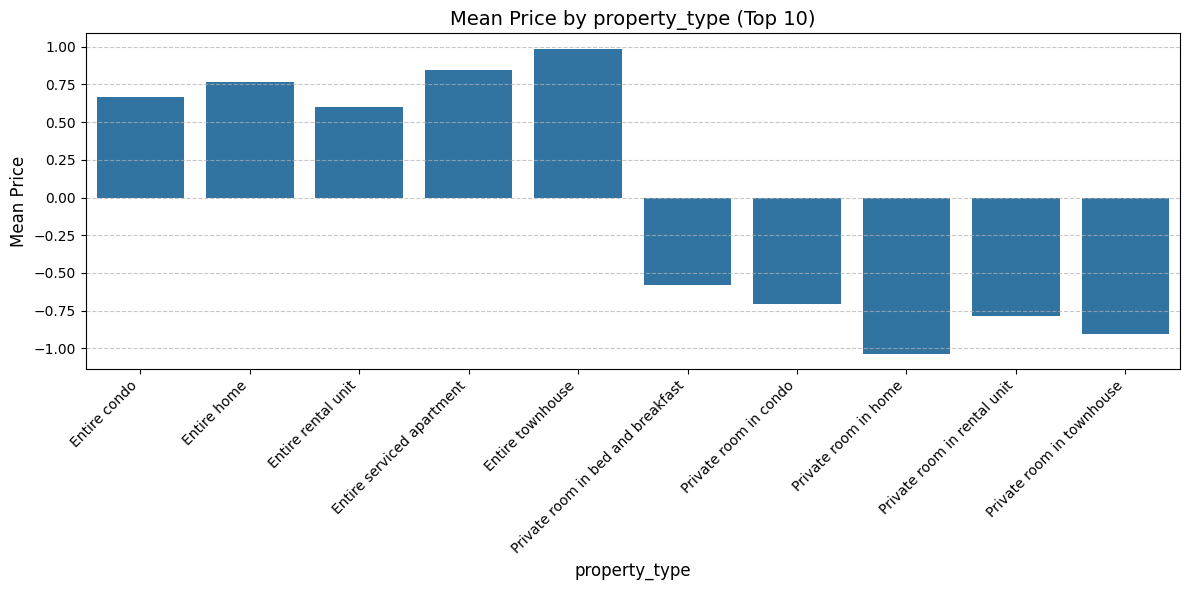

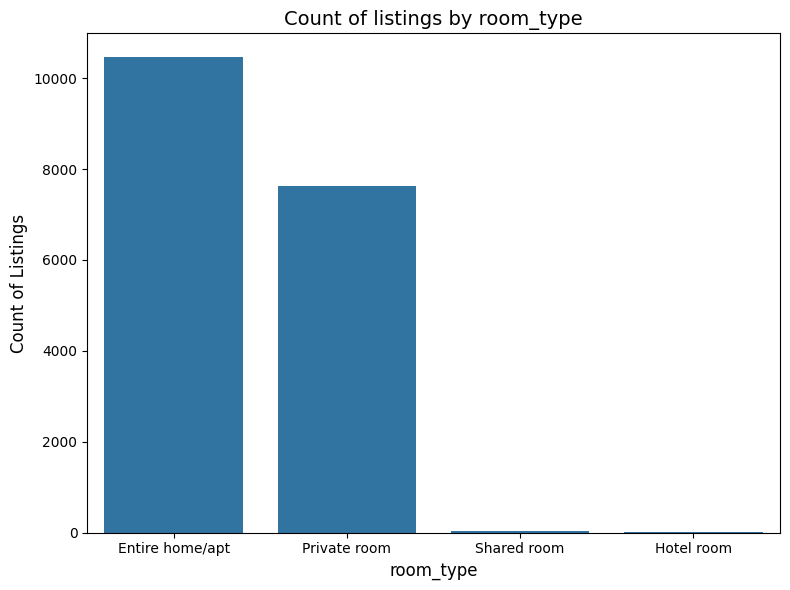

In [20]:
#prices_accross_neighbourhood(data)
x_vs_y_bar_plot(data, 'neighbourhood', 'log_price')
# the prices across number of possible tenants
plot_x_vs_y(data, 'accommodates', 'log_price')
# Does the average review rating affect the process?
plot_x_vs_y(data, 'review_scores_rating', 'log_price')
# get correlation matrix
correlation_matrix(data, 'log_price')
# get scatter matrix plot
# Select a subset of numerical variables
selected_variables =  [
    'log_price', 'accommodates', 'bedrooms',
    'beds', 'minimum_nights', 'bathrooms'
      ]
scatter_matrix_plot(data, selected_variables)
# get mean price by property type
mean_price_for_top_10_x(data, target_feature='property_type')
# get count of room_type in the dataset
plot_bar_count(data, target_feature='room_type')

# **Model Building**

In [21]:
def cross_validate_model(model_, X, y):
  """
  Cross-Validate a model
  model_: The model to be evaluated
  X: predictors
  y: target variable
  """
  # create 5 splits of the data
  k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
  # apply cross validation and get a list of  r^2 scores
  cv_scores = cross_val_score(model_, X, y, cv=k_fold, scoring='r2')
  # calculate mean squared error
  cv_mse_scores = -cross_val_score(
      model_, X, y, cv=k_fold, scoring='neg_mean_squared_error')
  # calculate root mean squared error
  cv_rmse_scores = np.sqrt(cv_mse_scores)
  # Mean Absolute Error (MAE)
  cv_mae_scores = -cross_val_score(model_, X, y, cv=k_fold,
                                   scoring='neg_mean_absolute_error')

  # print results
  print("\nEvaluating model using Cross-Validation (5-fold):")
  print(f"R² Scores for each fold: {cv_scores}")
  print(f"Mean R² Score: {cv_scores.mean():.4f}")
  print(f"Standard Deviation R² Score: {cv_scores.std():.4f}")
  print(f"RMSE Scores for each fold: {cv_rmse_scores}")
  print(f"Mean RMSE: {cv_rmse_scores.mean():.4f}")
  print(f"MAE Scores for each fold: {cv_mae_scores}")
  print(f"Mean MAE: {cv_mae_scores.mean():.4f}")


def evaluate_model_on_test(y_test, y_pred_test):
  """
  Evaluate the model on the test set by calcaulating
  the mean absolute error, root mean squared error, r^2, and print results
  y_test: test set for y
  y_pred_test: predicted values for y
  """
  # Evaluate the model on the test set
  mae = mean_absolute_error(y_test, y_pred_test)
  mse = mean_squared_error(y_test, y_pred_test)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred_test)

  # print results
  print("\nModel Evaluation on Test Set:")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"R² Score: {r2:.4f}")


In [22]:
def plot_qq(residuals):
  """
  QQ Plot of residuals to check normality
  residuals: Difference between actual and predicted values
  """
  plt.subplot(1, 2, 2)
  # create the plot
  stats.probplot(residuals, dist="norm", plot=plt)
  plt.title('Q-Q Plot of Residuals')
  plt.tight_layout()
  # save the figure
  plt.savefig('Q-Q Plot of Residuals')
  # show the plot
  plt.show()
  # close the plot
  plt.close()

def plot_actual_vs_predicted(y_test, y_pred_test):
  """
  Plot actual vs predicted prices
  y_test: test set for y
  y_pred_test: predicted values for y
  """
  plt.figure(figsize=(10, 6))
  # scter plot of actual and predicted value
  plt.scatter(y_test, y_pred_test, alpha=0.5)
  # add a diagonal reference line
  plt.plot([y_test.min(), y_test.max()],
          [y_test.min(), y_test.max()],
          'r--')
  plt.xlabel('Actual Price (£)')
  plt.ylabel('Predicted Price (£)')
  plt.title('Actual vs Predicted Prices')
  plt.grid(True, alpha=0.3)
  plt.savefig('Actual vs Predicted Prices')
  plt.show()
  # close the plot
  plt.close()

def plot_residuals(residuals, save=True):
  """
  Plot histogram of residuals
  residuals: Difference between actual and predicted values
  """

  # Create histgoram
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.hist(residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
  plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

  # Add title and lables
  plt.title('Histogram of Residuals')
  plt.xlabel('Residual Value')
  plt.ylabel('Frequency')
  plt.tight_layout()

  # Save plot if specified
  if save:
    plt.savefig('Histogram of Residuals')

  # Show figure
  plt.show()
  # close the plot
  plt.close()



Model Evaluation on Test Set:
Mean Absolute Error (MAE): 0.4144
Root Mean Squared Error (RMSE): 0.5302
R² Score: 0.7178
-----------------------------------

Evaluating model using Cross-Validation (5-fold):
R² Scores for each fold: [0.7177506  0.71071602 0.70717043 0.71322542 0.70910114]
Mean R² Score: 0.7116
Standard Deviation R² Score: 0.0037
RMSE Scores for each fold: [0.53021682 0.54290451 0.52914427 0.54491544 0.53736131]
Mean RMSE: 0.5369
MAE Scores for each fold: [0.41444131 0.42384624 0.41562609 0.42732688 0.41882114]
Mean MAE: 0.4200


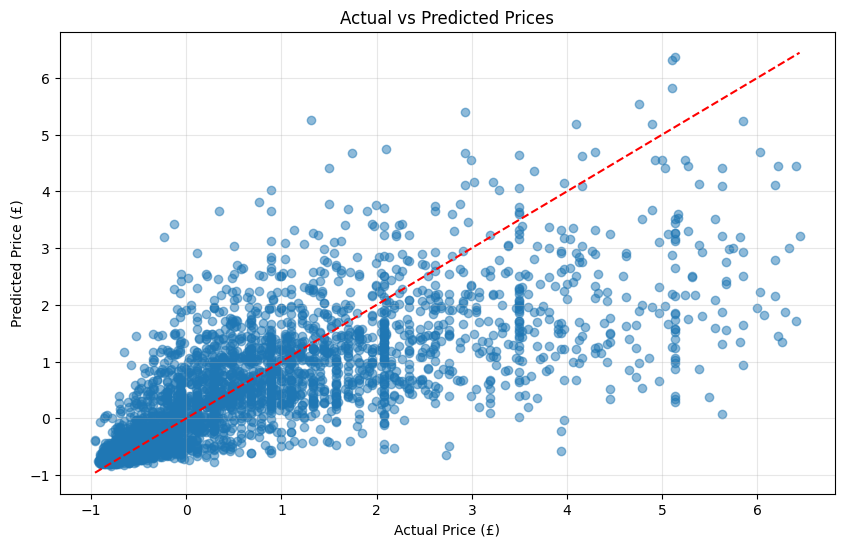

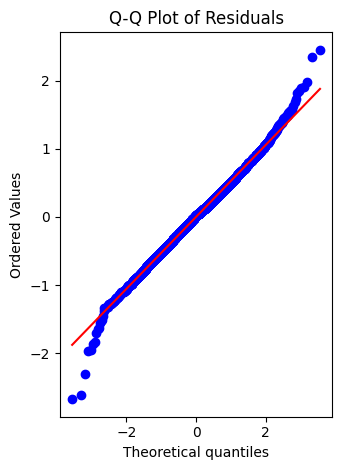

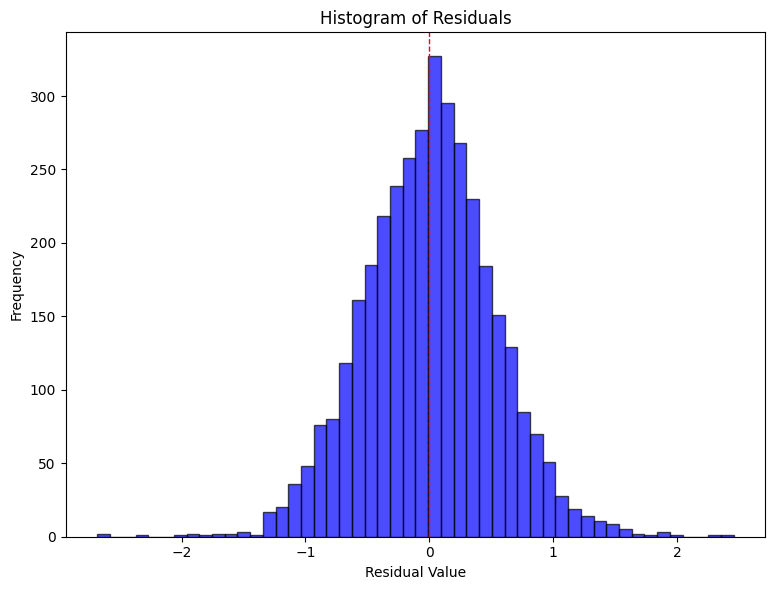

In [23]:
def build_and_eval_model(data, numerical_features, categorical_features,
                                plotting=True, rf=False, cv=True):
  """
  Build and evaluate a llinear or Random regression model for Airbnb
  price prediction
  data: A dataframe
  numerical_features: A list of numerical columns from the dataframe
  categorical_features: A list of categorical columns from the dataframe
  plotting: A boolean to plot the figures for evaluation
  rf: A boolean to indicate if random forest should be used
  cv: A boolean to indicate whether to perform cross-validation or not
  """
  # Create a copy of the dataframe using predictors
  X = data[numerical_features + categorical_features].copy()

  # Define y (target variable)
  y = data['log_price']

  #split to trianing and testing data
  X_train, X_test, y_train, y_test = (
      train_test_split(X, y, test_size=0.2, random_state=42))

  # Preprocessor with transformations
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
      ],
      remainder='passthrough'
  )

  if rf:
    # use random forest model
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
  else:
    # use linear regression model
    model = LinearRegression()

  # Create the model pipeline
  model_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('regressor', model)
  ])

  model_pipeline.fit(X_train, y_train)

  # Make predictions
  y_pred_train = model_pipeline.predict(X_train)
  y_pred_test = model_pipeline.predict(X_test)

  evaluate_model_on_test(y_test, y_pred_test)
  print('-----------------------------------')
  if cv:
    cross_validate_model(model_pipeline, X, y)

  if plotting:
    # Convert predictions back to original scale for interpretation
    y_test_exp = np.expm1(y_test)
    y_pred_test_exp = np.expm1(y_pred_test)

    # pass the exponential of the price to convert it back to the original scale
    plot_actual_vs_predicted(y_test_exp, y_pred_test_exp)

    # Calculate residuals
    residuals = y_test - y_pred_test
    # plot qq, to check for normality
    plot_qq(residuals)

    # Plot histogram of residuals (log scale)
    plot_residuals(residuals)



# Select the predictors that would have impact in predicting the AirBnb prices.
numerical_features = ['accommodates', 'bedrooms', 'beds',
                      'minimum_nights', 'bathrooms']
categorical_features = ['property_type', 'room_type',
                        'neighbourhood', 'host_is_superhost']
# build, and evaluate the model
build_and_eval_model(data, numerical_features, categorical_features, True)

# **Part 2: Improved model**

# **Clustering**

In [24]:
def visualize_clusters_pca(data, cluster_labels, k_value):
    """
    Visualizes clusters in 2D using PCA.
    data: A dataset
    cluster_labels: Lables produced by K-Means
    k_value: Number of clusters, to be used in the title

    """
    pca = PCA(n_components=2) # 2D
    pcs = pca.fit_transform(data)
    # Create a dataframe with the principal componants (pcs)
    pca_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
    # Add a column for the cluster labels
    pca_df['cluster'] = cluster_labels
    # plot the dataframe
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='PC1',
        y='PC2',
        hue='cluster',
        data=pca_df,
        palette=sns.color_palette("tab10", n_colors=k_value))
    # Add title and labels
    plt.title(f'K-Means Clusters with PCA (K={k_value})')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()
    # close the plot
    plt.close()

def plot_elbow_curve(k_range, inertia_values):
  """
  data: A dataset
  inertial_values: cost values from the k-means algorithms
  k_range: Range of the number of clusters
  """
  # Plot the elbow curve
  plt.figure(figsize=(8, 6))
  plt.plot(k_range, inertia_values, marker='o')
  plt.title('Elbow Method for determining Optimal K')
  plt.xlabel('Number of Clusters (K)')
  plt.ylabel('Cost')
  plt.xticks([0, 10, 20, 30, 40, 50])
  plt.grid(True)
  plt.show()
  # close the plot
  plt.close()


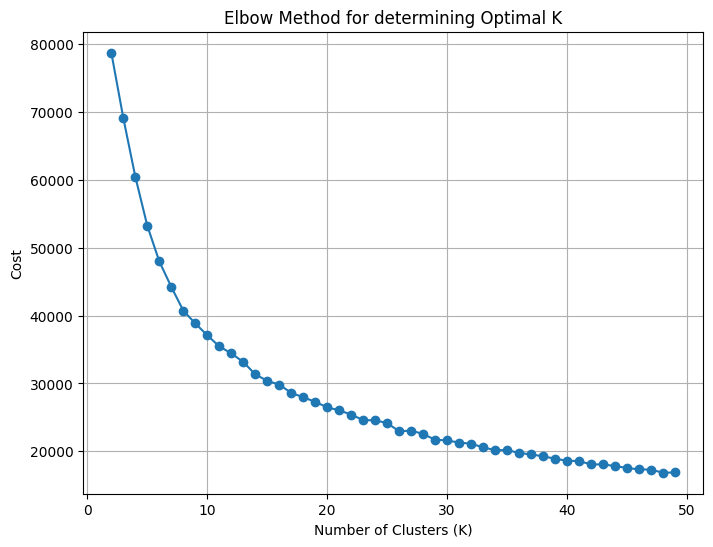

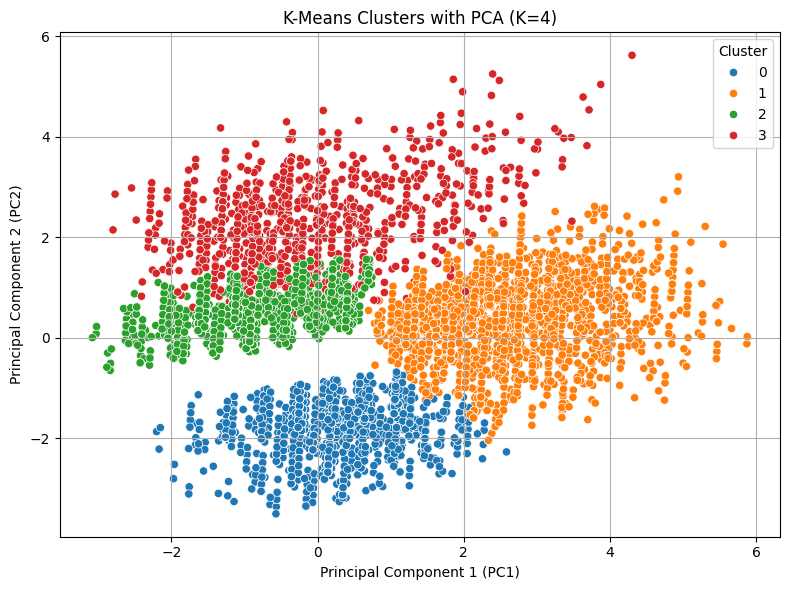

Cluster sizes:
|    |   Cluster |   Count |
|---:|----------:|--------:|
|  0 |         0 |    4075 |
|  1 |         1 |    3719 |
|  2 |         2 |    8757 |
|  3 |         3 |    1614 | 


Cluster Characteristics:
|   Cluster |   accommodates |   bedrooms |      beds |   minimum_nights |   bathrooms |   host_total_listings_count |
|----------:|---------------:|-----------:|----------:|-----------------:|------------:|----------------------------:|
|         0 |      -0.383846 |  -0.410315 | -0.29661  |        1.16981   |   -0.190029 |                   -0.235185 |
|         1 |       1.37408  |   1.56749  |  1.03325  |        0.25601   |    0.733322 |                   -0.131567 |
|         2 |      -0.437691 |  -0.428624 | -0.343536 |       -0.645556  |   -0.202292 |                   -0.275922 |
|         3 |       0.177722 |  -0.250308 |  0.231958 |       -0.0408498 |   -0.112382 |                    2.39401  | 


Price summary
|   Cluster |   log_price |
|----------:|-----------

In [25]:
def cluster_data(data, numerical_features, categorical_features, k_value):
  """
  A method to cluster a dataframe using kmeans, print the elbow plot, print
  summary stats about key features within clusters and return
  the clustered data.
  data: A dataset
  numerical_features: A list of numerical columns from the dataset
  categorical_features: A list of categorical columns from the dataset
  k_value: Number of clusters
  """

  clustered_data = data[numerical_features].copy()

  inertia_values = []
  k_range = range(2, 50)

  for k in k_range:
      kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
      kmeans.fit(clustered_data)
      inertia_values.append(kmeans.inertia_)

  # plot the elbow curve
  plot_elbow_curve(k_range, inertia_values)
  # initialize kmeans alogrithm
  kmeans_k = KMeans(n_clusters=k_value, random_state=42, n_init=10)
  # fit the algorithm on the data
  kmeans_k.fit(clustered_data)
  # Get cluster labels
  cluster_labels_k = kmeans_k.labels_
  # add the labels to the dataframe
  clustered_data['Cluster'] = cluster_labels_k
  # use PCA to viaulize the clusters on a 2D plot
  visualize_clusters_pca(clustered_data, cluster_labels_k, k_value=k_value)

  # print a table of the size of each cluster
  cluster_count = (
    clustered_data.groupby('Cluster').size().reset_index(name='Count'))
  print("Cluster sizes:")
  print(cluster_count.to_markdown(), '\n')


  # claculate the mean for the numerical features in each cluster
  cluster_summary = clustered_data.groupby('Cluster')[numerical_features].mean()
  print("\nCluster Characteristics:")
  # print as a markdown table
  print(cluster_summary.to_markdown(), '\n')
  print("\nPrice summary")
  # create a copy of the dataframe with the cluster labels
  clustered_data_with_price = clustered_data.copy()
  # add the price column to the new dataframe
  clustered_data_with_price['log_price'] = data['log_price']
  # group by cluster and calculate the mean price
  price_summary = (clustered_data_with_price.
                   groupby('Cluster')['log_price'].mean())
  # print as a markdown table
  print(price_summary.to_markdown(), '\n')

  # get The distribution of categorical variables across clusters
  for feature in categorical_features:
    print(f"Distibution of {feature}")
    cluster_distribution = (pd.crosstab(clustered_data['Cluster'],
                                         data[feature], normalize='index')
                                         * 100) # to make it a percentage
    # Convert DataFrame to Markdown table
    print('\n', cluster_distribution.to_markdown(), '\n')

  return clustered_data


numerical_features = ['accommodates', 'bedrooms', 'beds',
                      'minimum_nights', 'bathrooms',
                      'host_total_listings_count']
categorical_features = ['neighbourhood', 'property_type', 'room_type']
num_of_clusters = 4

clustered_data = cluster_data(data, numerical_features, categorical_features, k_value=num_of_clusters)

# **Local Regressors**

In [26]:
# Select the same predictors that were used in the basic model.
numerical_features = ['accommodates', 'bedrooms', 'beds',
                      'minimum_nights', 'bathrooms']
categorical_features = ['property_type', 'room_type',
                        'neighbourhood', 'host_is_superhost']


# Add cluster labels to the original data
clustered_data['index_col'] = data.index
data_with_cluster = pd.merge(
    data, clustered_data[['index_col', 'Cluster']],
    left_index=True, right_on='index_col'
).drop(columns=['index_col'])

# Iterate over each cluster, filter data, build, and evaluate the model
for cluster_id in range(num_of_clusters):
    print(f'\nCluster {cluster_id}')
    cluster_data = data_with_cluster[data_with_cluster['Cluster'] ==
                                     cluster_id].drop(columns=['Cluster'])
    build_and_eval_model(cluster_data,
                         numerical_features,
                         categorical_features,
                         plotting=False
                         )


Cluster 0

Model Evaluation on Test Set:
Mean Absolute Error (MAE): 0.3856
Root Mean Squared Error (RMSE): 0.5057
R² Score: 0.7139
-----------------------------------

Evaluating model using Cross-Validation (5-fold):
R² Scores for each fold: [0.71393312 0.69570203 0.68470999 0.66281869 0.65461048]
Mean R² Score: 0.6824
Standard Deviation R² Score: 0.0216
RMSE Scores for each fold: [0.50568311 0.53215035 0.5343695  0.55509581 0.53802118]
Mean RMSE: 0.5331
MAE Scores for each fold: [0.38564867 0.41925073 0.42213211 0.43533562 0.42057905]
Mean MAE: 0.4166

Cluster 1

Model Evaluation on Test Set:
Mean Absolute Error (MAE): 0.4068
Root Mean Squared Error (RMSE): 0.5118
R² Score: 0.3713
-----------------------------------

Evaluating model using Cross-Validation (5-fold):
R² Scores for each fold: [0.37134531 0.39045961 0.40718046 0.35341103 0.36637302]
Mean R² Score: 0.3778
Standard Deviation R² Score: 0.0189
RMSE Scores for each fold: [0.51176869 0.47184024 0.47719459 0.49512689 0.511088

# **Improved model building using Random Forest**

# **Check the distributions of numerical variables**

In [27]:
def plot_numerical_histograms_combined(data):
    """Generate and save histograms for all numerical columns."""
    numerical_variables, _ = get_numeric_and_categorical(data)

    data[numerical_variables].hist(
        bins=15, figsize=(12, 8), layout=(-1, 3), edgecolor="black"
    )

    plt.tight_layout()
    plt.savefig("numerical_histograms.png")
    plt.show()


Shape of data before cleaning: (66679, 31)
Summary Statistics: 
|                                |   count |   unique | top                                                                         |   freq |           mean |           std |        min |           25% |           50% |           75% |             max |
|:-------------------------------|--------:|---------:|:----------------------------------------------------------------------------|-------:|---------------:|--------------:|-----------:|--------------:|--------------:|--------------:|----------------:|
| id                             |   66679 |      nan | nan                                                                         |    nan |    6.12924e+17 |   4.72814e+17 | 13913      |   3.98249e+07 |   8.04e+17    |   1.03e+18    |     1.18e+18    |
| name                           |   66679 |    64452 | Flat in London                                                              |     25 |  nan           | nan        

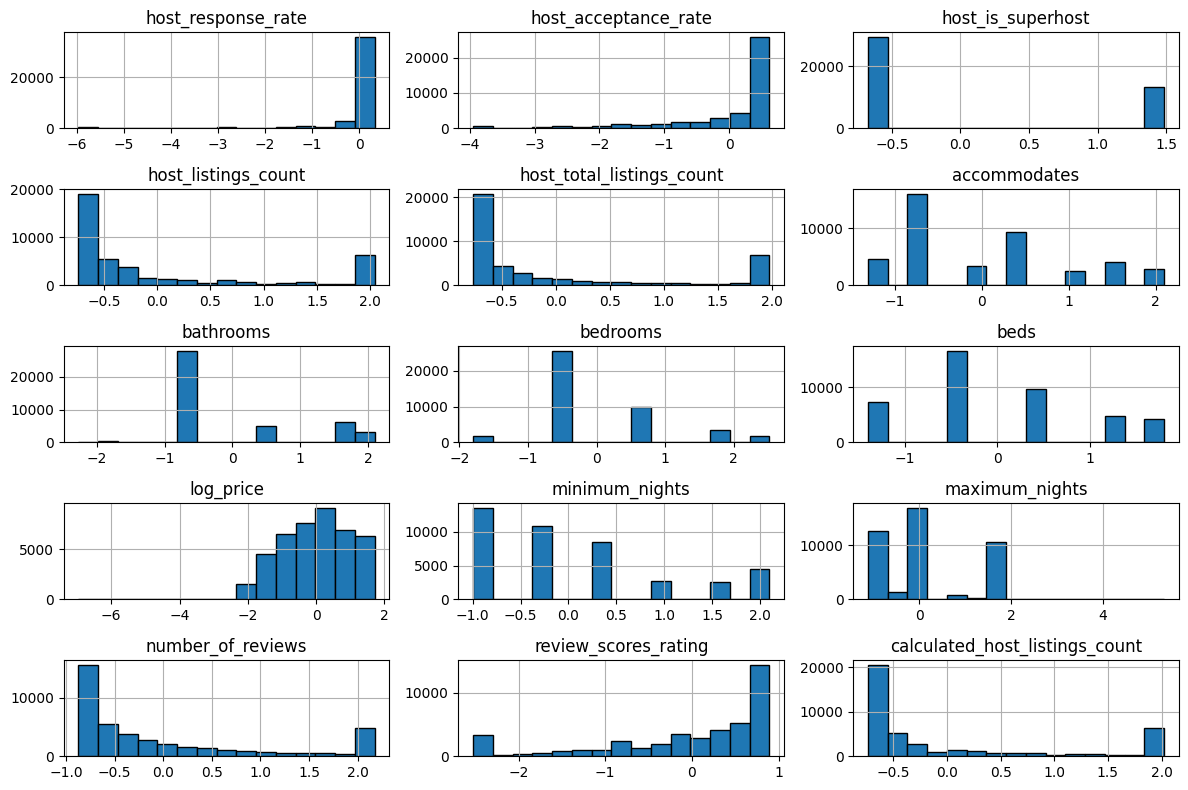

In [28]:
# Redo data cleaning using outlier capping instead of removal
capped_data = load_and_clean_data('London_Listings.csv', handle_outlier='cap_iqr')
# Plot distibutions of numerical variables
plot_numerical_histograms_combined(capped_data)

# **Handle Skewed variables identified in the previous plot**

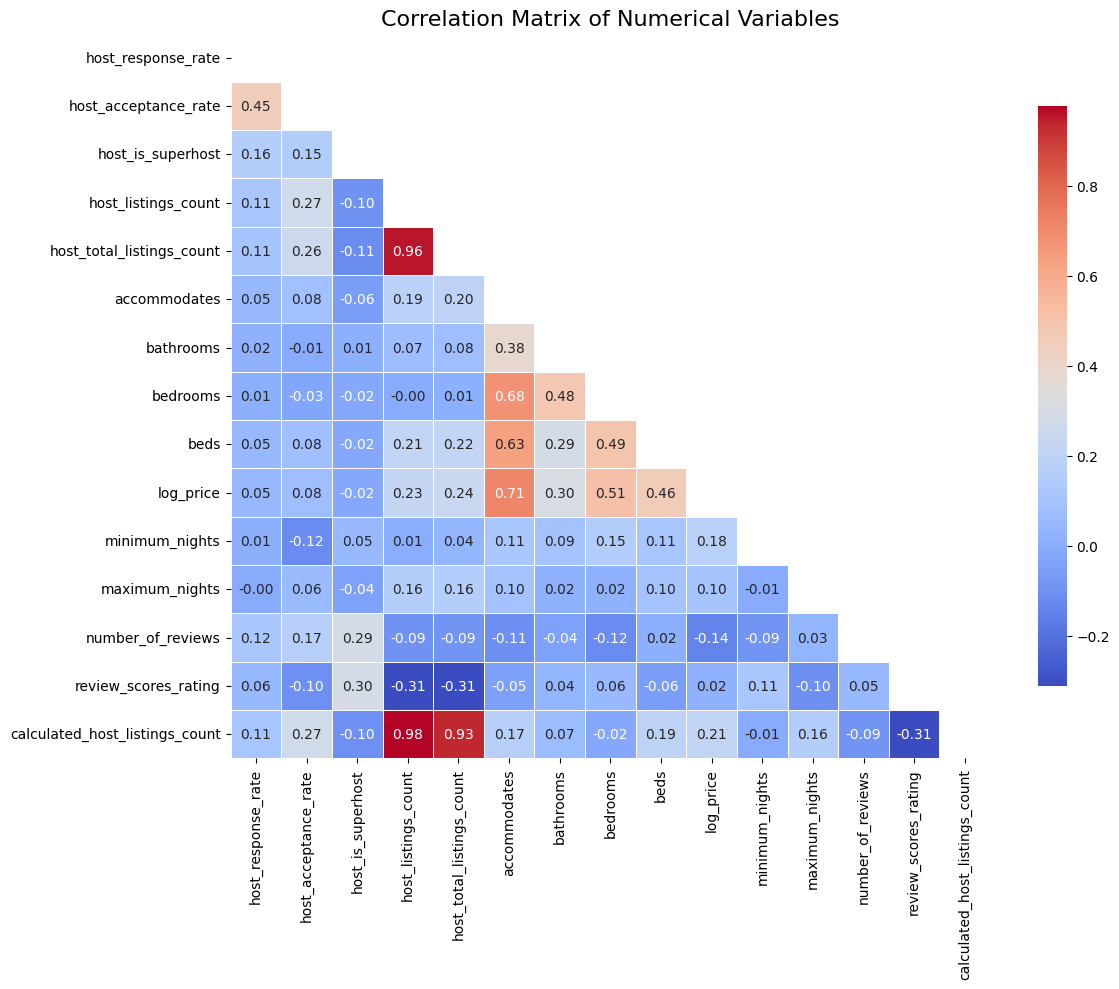

Top correlations with log_price:
log_price                         1.000000
accommodates                      0.712364
bedrooms                          0.511140
beds                              0.457450
bathrooms                         0.303817
host_total_listings_count         0.237461
host_listings_count               0.227061
calculated_host_listings_count    0.211004
minimum_nights                    0.176927
maximum_nights                    0.104889
host_acceptance_rate              0.075975
host_response_rate                0.048254
review_scores_rating              0.024378
host_is_superhost                -0.018620
number_of_reviews                -0.144520
Name: log_price, dtype: float64


In [29]:
def handle_skewed(data, columns):
  """
  A mthod to apply yeo-johnson power transformation on a set of columns in a
  dataframe.
  data: A data frame
  columns: columns from the dataframe.
  """
  # Check if all columns are present in the dataframe
  for col in columns:
    if col not in data.columns:
      print(f'Column: {col} not found in the dataframe!')
      # return the dataframe as is
      return data

  pt = PowerTransformer(method='yeo-johnson')
  data[columns] = pt.fit_transform(data[columns])
  return data

numerical_features = ['accommodates', 'bedrooms', 'beds', 'minimum_nights',
                      'bathrooms', 'host_total_listings_count',
                      'host_listings_count', 'calculated_host_listings_count',
                      'maximum_nights'
                      ]
capped_data = handle_skewed(capped_data, numerical_features)

correlation_matrix(capped_data, 'log_price')

# **Train and Validate the RF model**


Model Evaluation on Test Set:
Mean Absolute Error (MAE): 0.3343
Root Mean Squared Error (RMSE): 0.4506
R² Score: 0.7999
-----------------------------------

Evaluating model using Cross-Validation (5-fold):
R² Scores for each fold: [0.79996819 0.79159059 0.78524295 0.78764103 0.78622877]
Mean R² Score: 0.7901
Standard Deviation R² Score: 0.0054
RMSE Scores for each fold: [0.45053229 0.45674362 0.46538493 0.4557289  0.46182218]
Mean RMSE: 0.4580
MAE Scores for each fold: [0.33468478 0.33695693 0.34044647 0.33827744 0.34137548]
Mean MAE: 0.3383


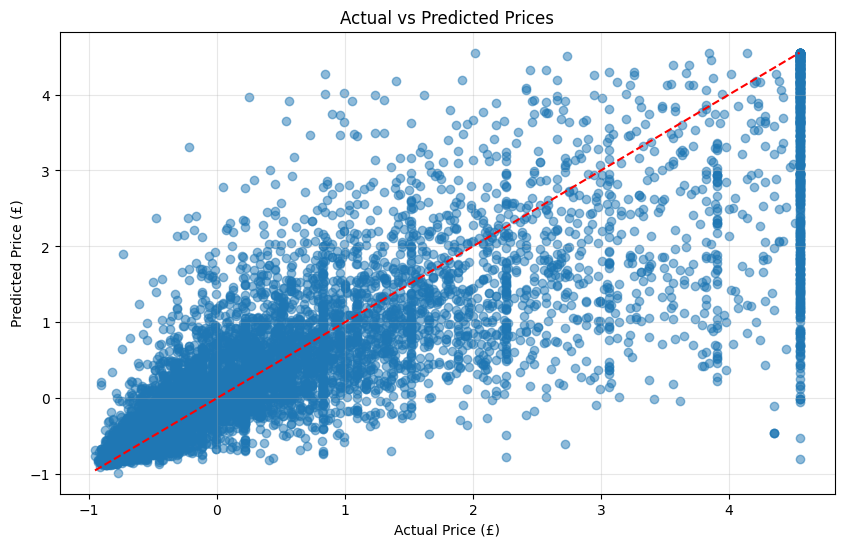

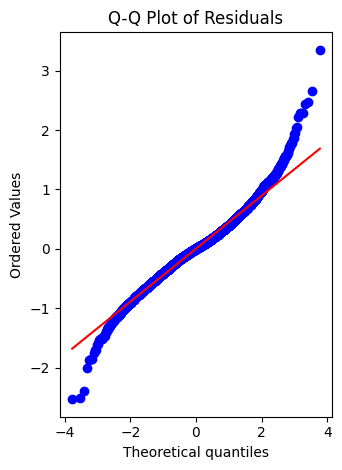

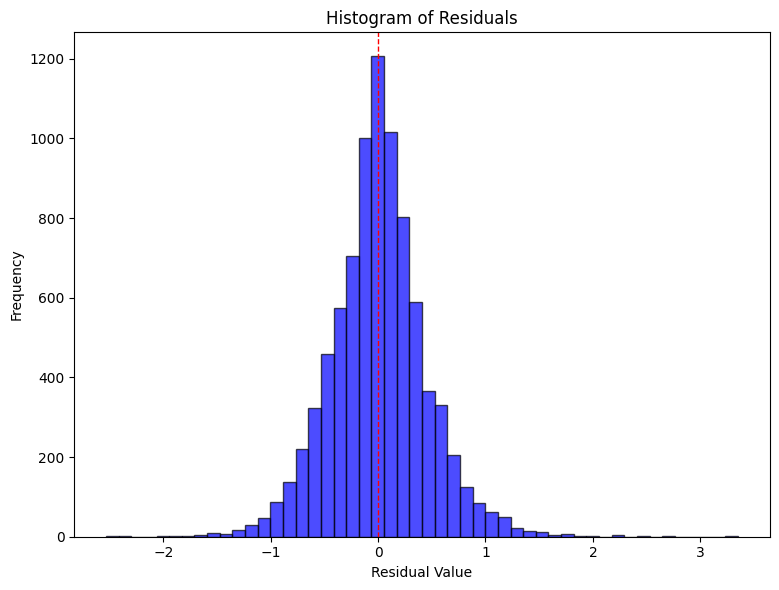

In [ ]:
# Select the predictors that would have impact in predicting the AirBnb prices.
numerical_features = ['accommodates', 'bedrooms', 'beds', 'minimum_nights',
                      'bathrooms', 'host_total_listings_count',
                      'host_listings_count', 'calculated_host_listings_count',
                      'maximum_nights'
                      ]
categorical_features = ['property_type', 'room_type', 'neighbourhood', 'host_is_superhost']
# build random forest regression model (rf=True)
build_and_eval_model(capped_data,
                     numerical_features,
                     categorical_features,
                     plotting=True,
                     rf=True,
                     cv=True)